In [8]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
import platform
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [19]:
home_directory = os.path.expanduser('~')
system_type = platform.system()

# デフォルトの OneDrive フォルダ名
onedrive_path = None
if system_type == "Windows":
    # Windows では環境変数が使える（MS公式な方法）
    onedrive_path = os.environ.get("OneDrive")
    if onedrive_path is None:
        # フォールバック
        onedrive_path = os.path.join(home_directory, "OneDrive")
elif system_type == "Darwin": 
    onedrive_path = os.path.join(home_directory, "Library", "CloudStorage", "OneDrive-個人用(2)")

print(f"OneDrive path: {onedrive_path}")



OneDrive path: /Users/konishi/Library/CloudStorage/OneDrive-個人用(2)


In [10]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

tf_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
tf_test  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

root = os.path.join(onedrive_path,'CODES','samples','Fmnist_data')
Fmnist_train = datasets.FashionMNIST(root=root,download=True,train=True,transform=tf_train)
Fmnist_test = datasets.FashionMNIST(root=root,download=True,train=False,transform=tf_test)
test_dataloader = DataLoader(Fmnist_test,batch_size=batch_size,shuffle=False)

In [11]:
def get_new_dataloader(Fmnist_train,batch_size):
    train_dataloader = DataLoader(Fmnist_train,batch_size=batch_size,shuffle=True)
    return train_dataloader

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [13]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [14]:
#EncoderPM
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)
        self.alpha.requires_grad = False

    def forward(self, x):

        b, n_patches,  k, _ = x.shape
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x

In [15]:
class CNN(nn.Module):
    def __init__(self,img_size,channels):
        super(CNN, self).__init__()
        ch1 = 16
        ch2 = 32
        self.conv1 = nn.Conv2d(channels, ch1, kernel_size=3, padding=1)
        # 32チャネル -> 64チャネル
        self.conv2 = nn.Conv2d(ch1, ch2, kernel_size=3, padding=1)
        # プーリング層
        self.pool = nn.MaxPool2d(2, 2)

        self.norm1 = nn.BatchNorm2d(ch1)
        self.norm2 = nn.BatchNorm2d(ch2)
        self.fc1 = nn.Linear(ch2 * (img_size//4) * (img_size//4), 256)
        self.fc2 = nn.Linear(256, 10)  # 10クラス
        self.func = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.func(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.func(x)
        x = self.pool(x)  # conv2 → ReLU → Pool
        x = x.view(x.size(0), -1)  # フラット化 (batch, 64*8*8)= nn.MaxPool2d(2, 2)
        # 全結合層
        x = self.func(self.fc1(x))          # 全結合1 → ReLU
        x = self.fc2(x)              # 全結合2 (出力)
        return x


In [16]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()

        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = channels*kernel_size**2
        feat_dim = int(kernel_in/leverage)
        n_patches = (28//kernel_size)*(28//kernel_size)
        self.side = int(np.sqrt(n_patches))

        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.bn = nn.BatchNorm2d(feat_dim)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self.classifier =  CNN(self.side,feat_dim)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = self.split(x, self.kernel_size) 
        x = self.encoder(x)
        x = x.view(b, self.side, self.side, -1).permute(0, 3, 1, 2)  
        #print(x.shape)
        x = self.bn(x)
        x = self.classifier(x)
        return x

1:1 1th Epoch: 19/20

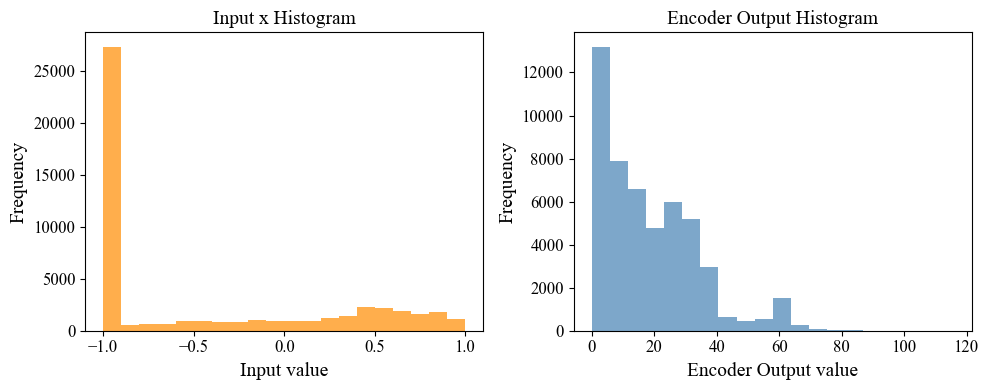

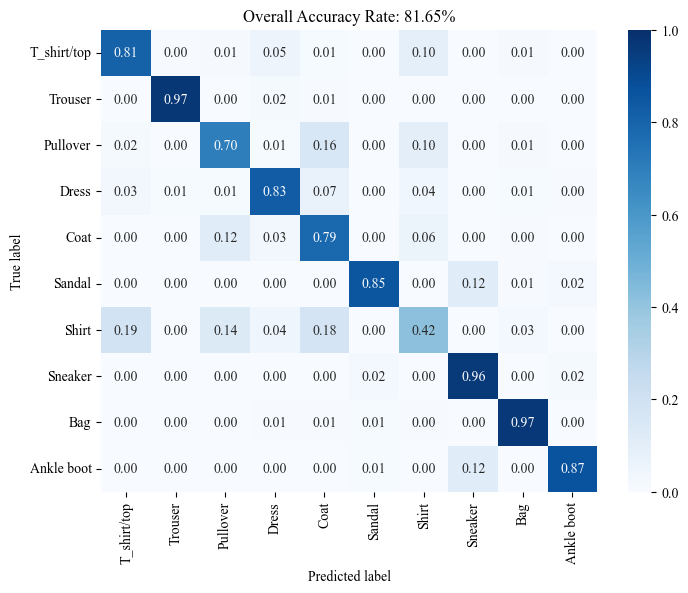

1:1 2th Epoch: 19/20

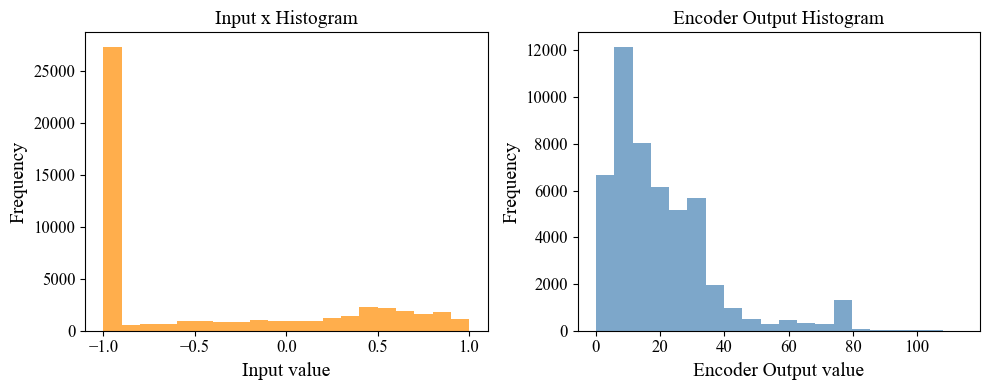

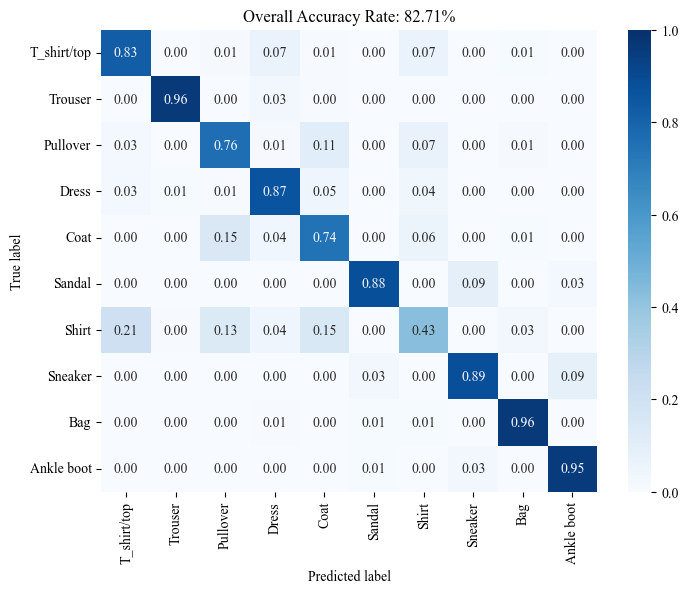

1:1 3th Epoch: 19/20

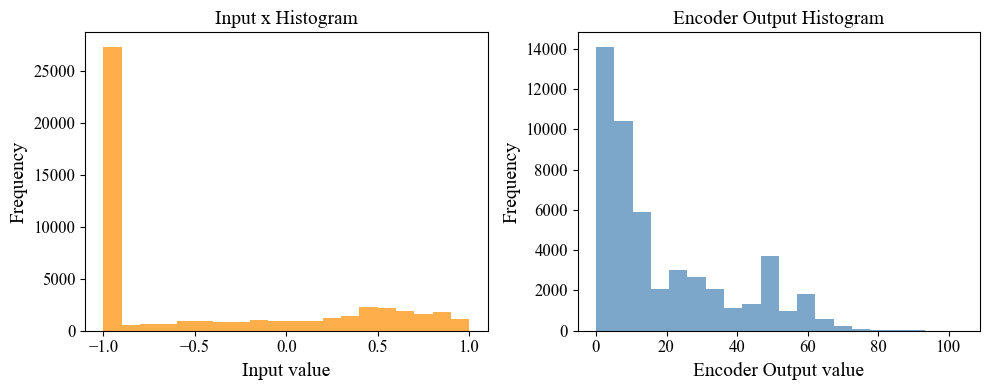

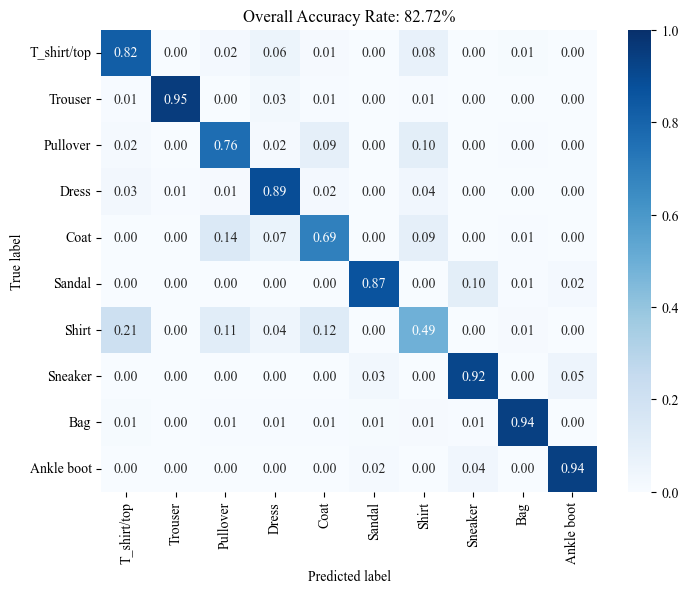

1:1 4th Epoch: 19/20

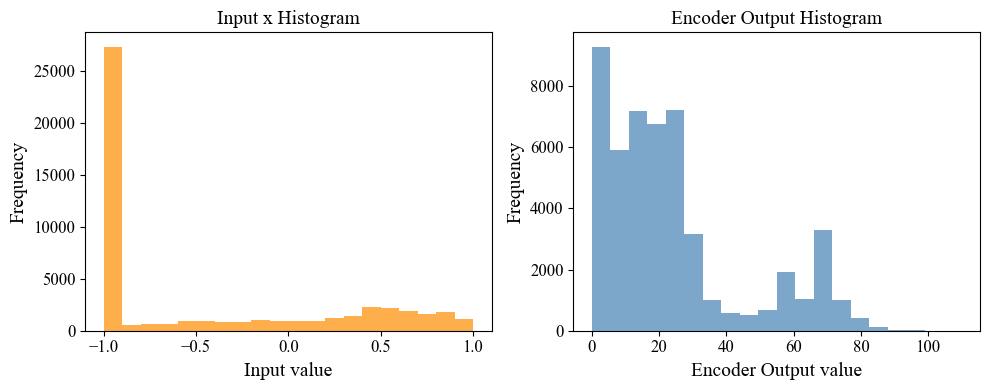

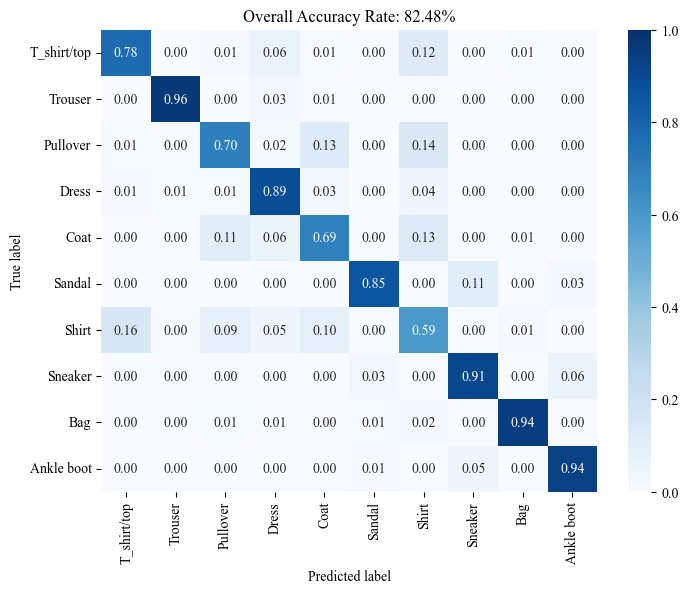

1:1 5th Epoch: 19/20

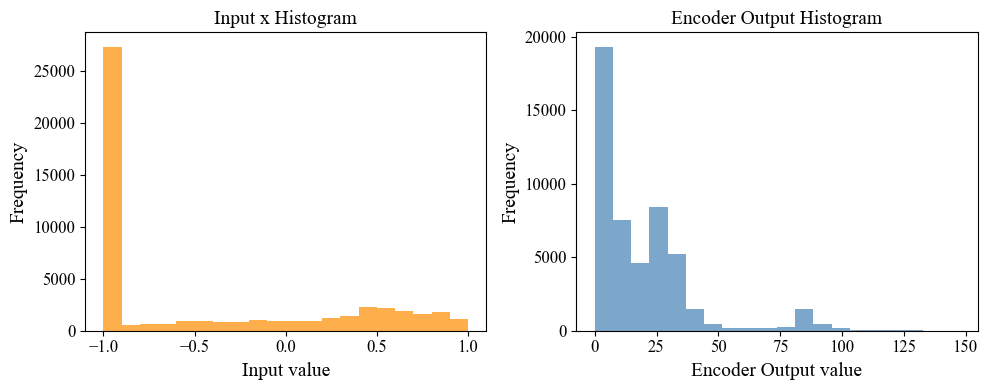

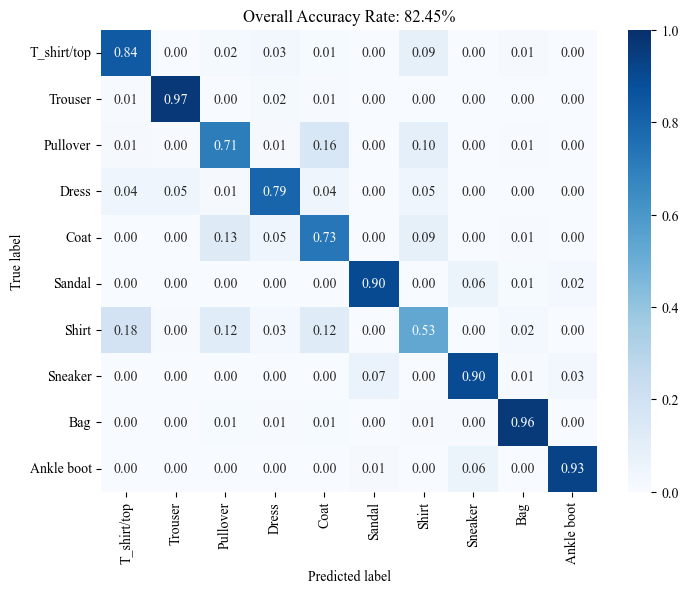

           Average  Best ID       Best  Worst ID      Worst
0   ACC  82.402000        3  82.720000         1  81.650000
1  LOSS   0.466588        2   0.457523         1   0.481327


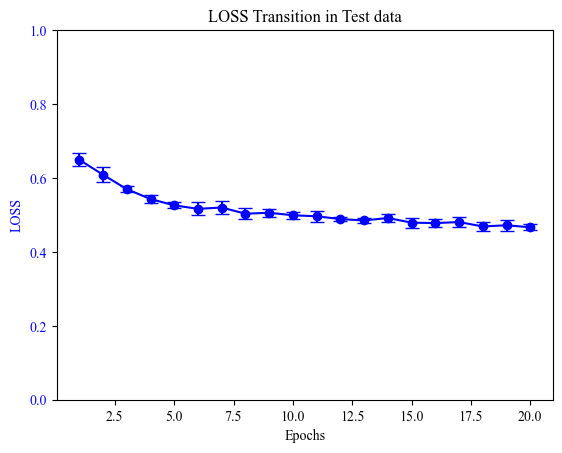

1:2 1th Epoch: 19/20

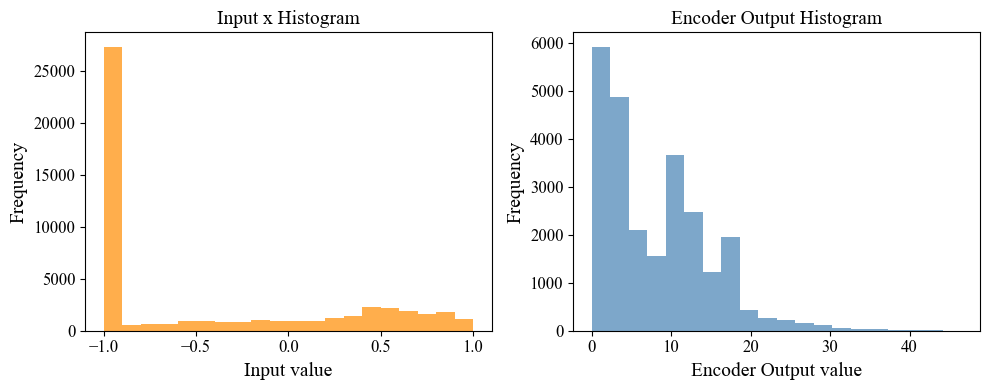

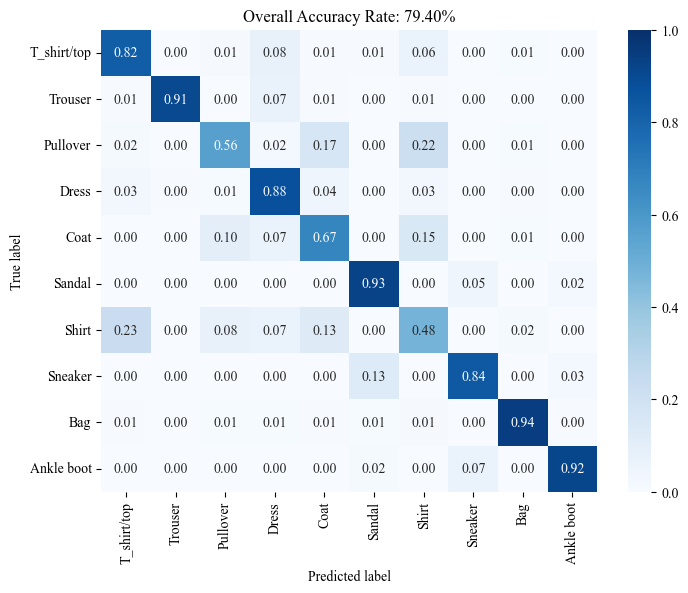

1:2 2th Epoch: 19/20

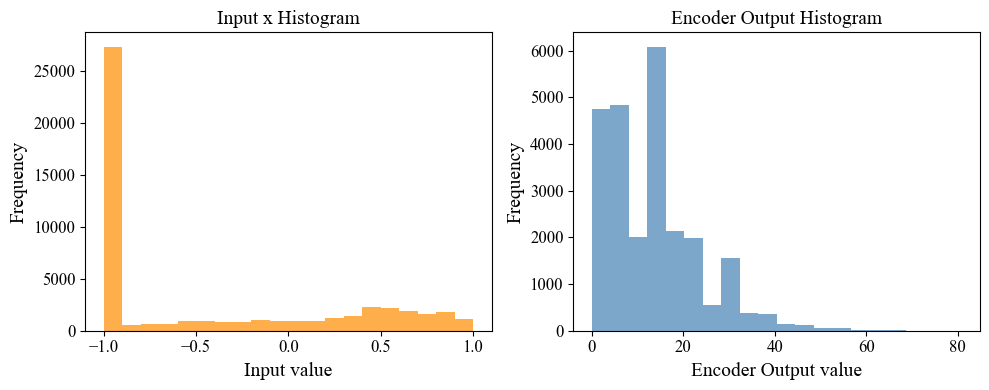

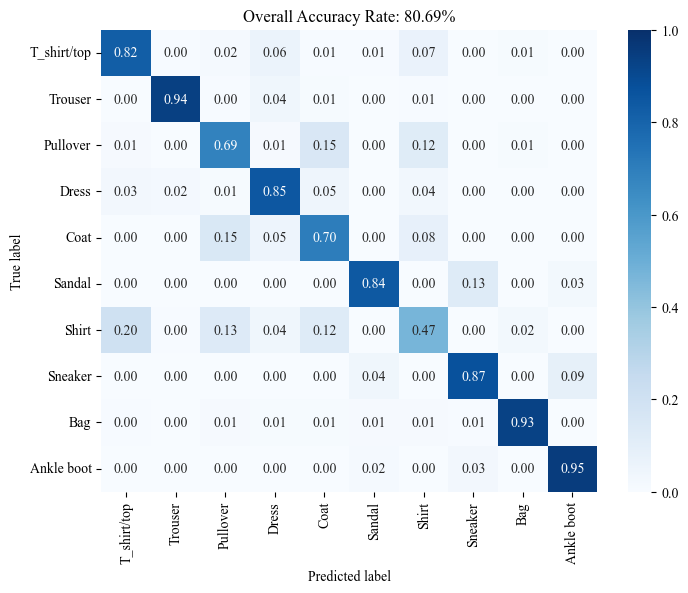

1:2 3th Epoch: 19/20

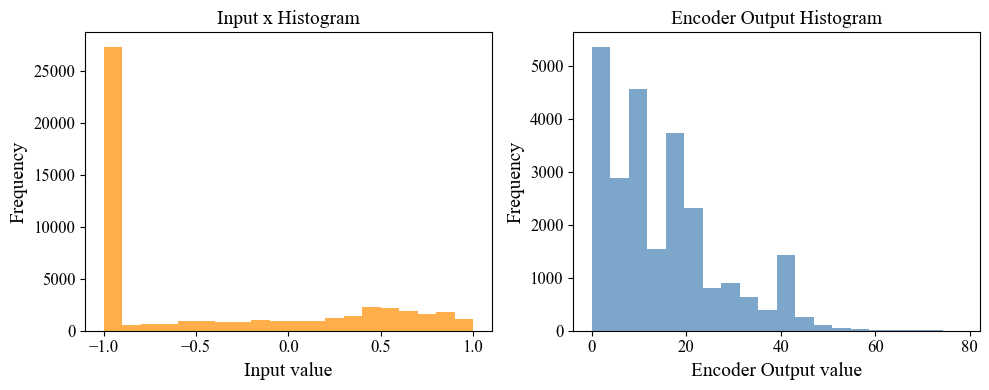

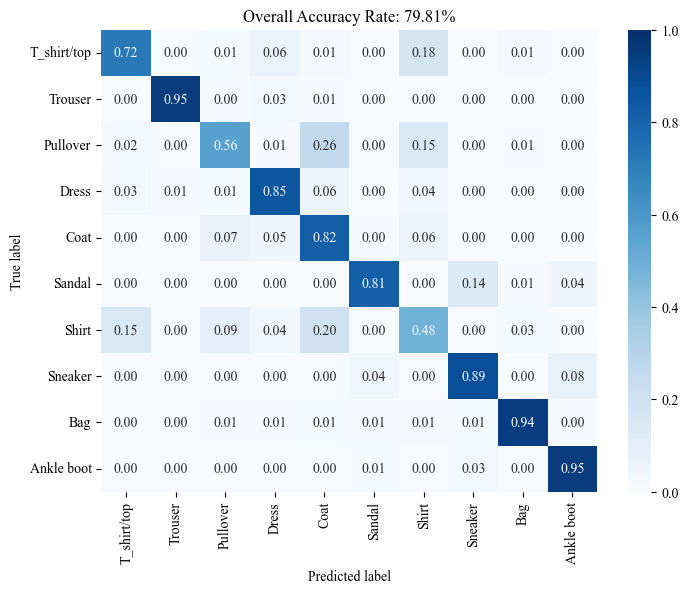

1:2 4th Epoch: 19/20

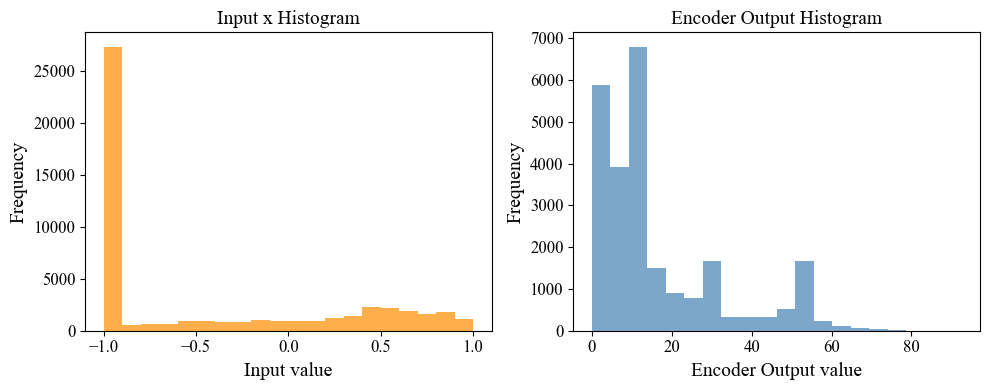

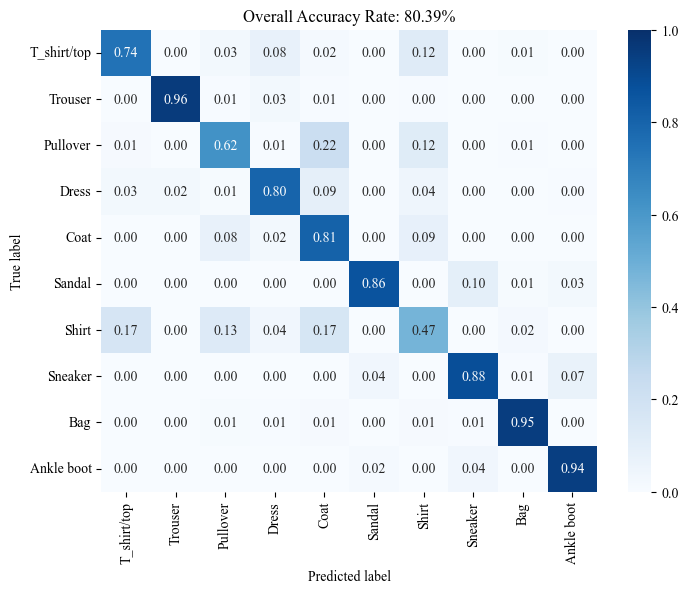

1:2 5th Epoch: 19/20

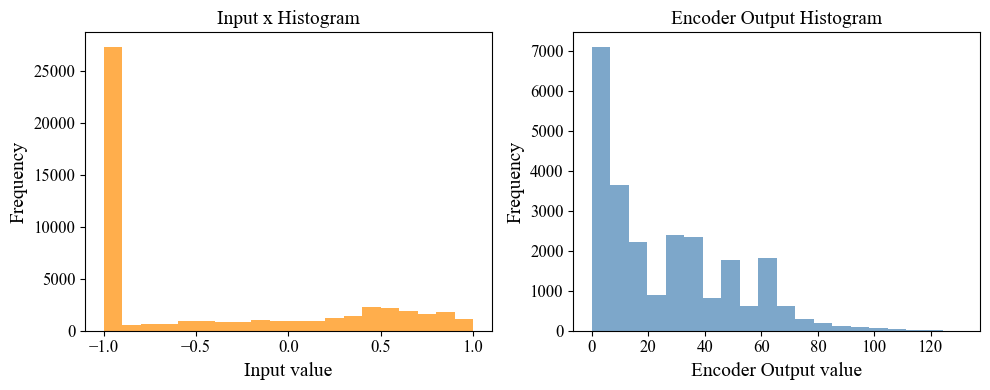

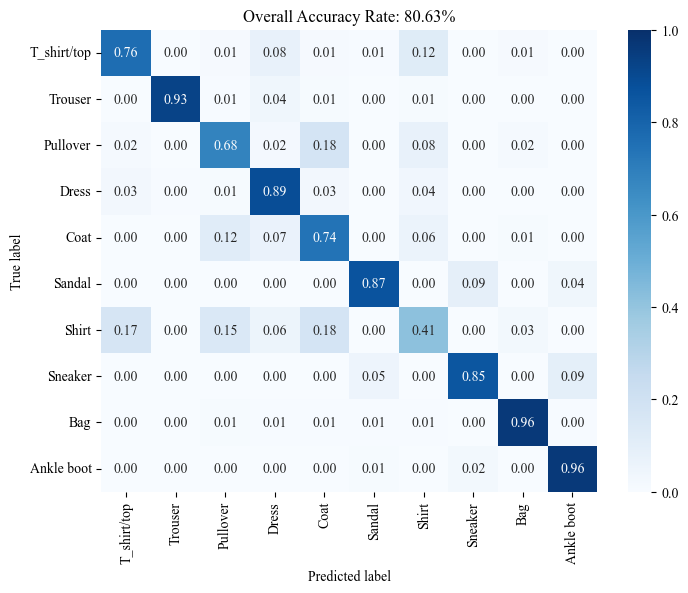

          Average  Best ID       Best  Worst ID      Worst
0   ACC  80.18400        2  80.690000         1  79.400000
1  LOSS   0.51574        5   0.505265         1   0.532442


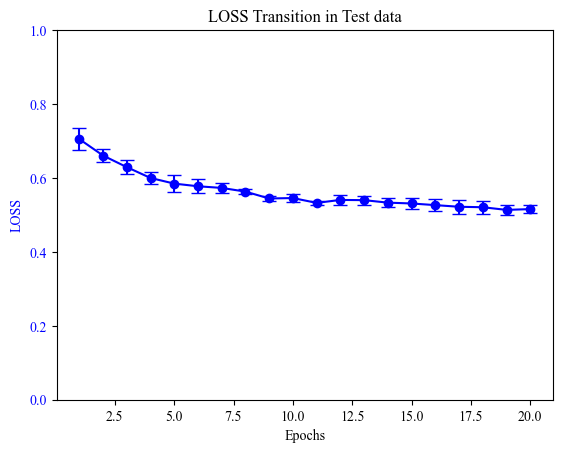

1:4 1th Epoch: 19/20

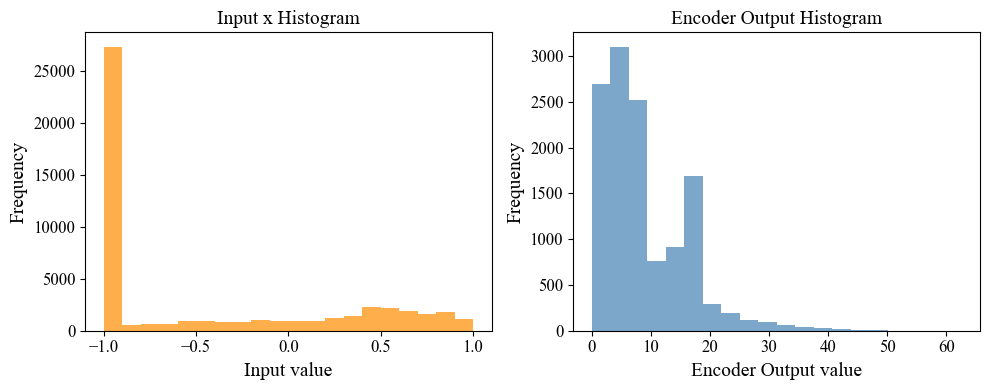

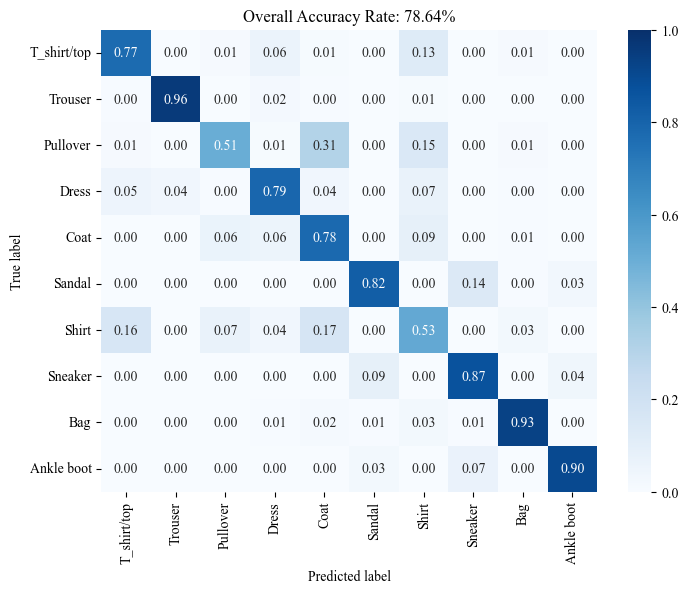

1:4 2th Epoch: 19/20

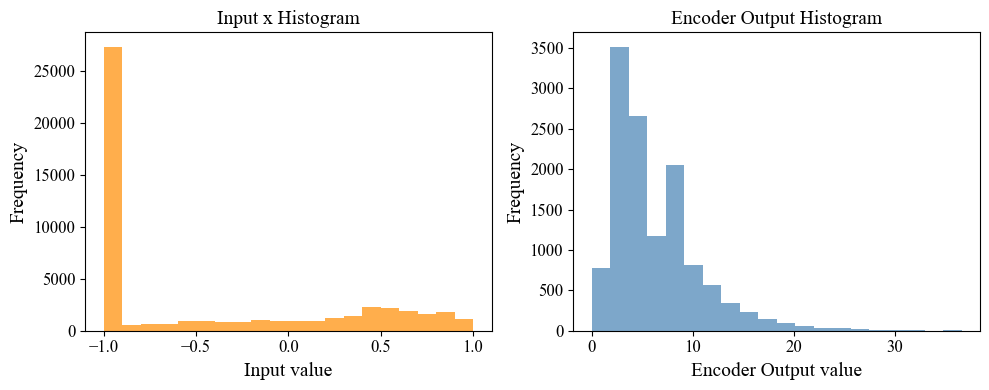

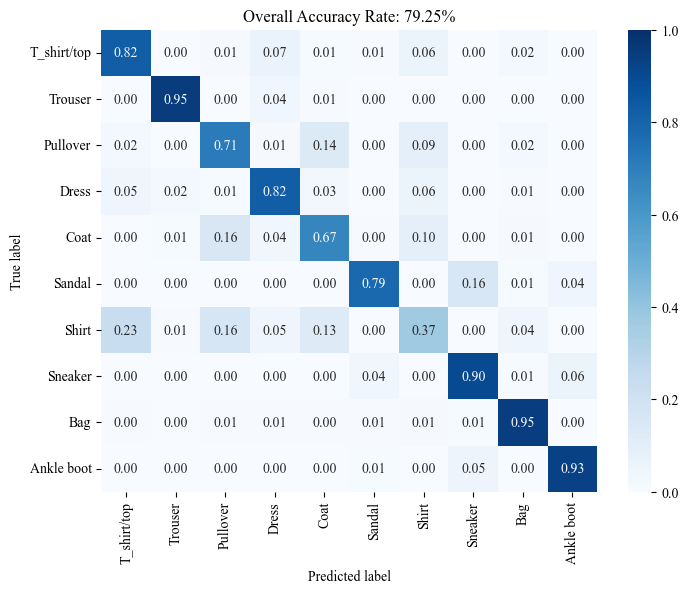

1:4 3th Epoch: 19/20

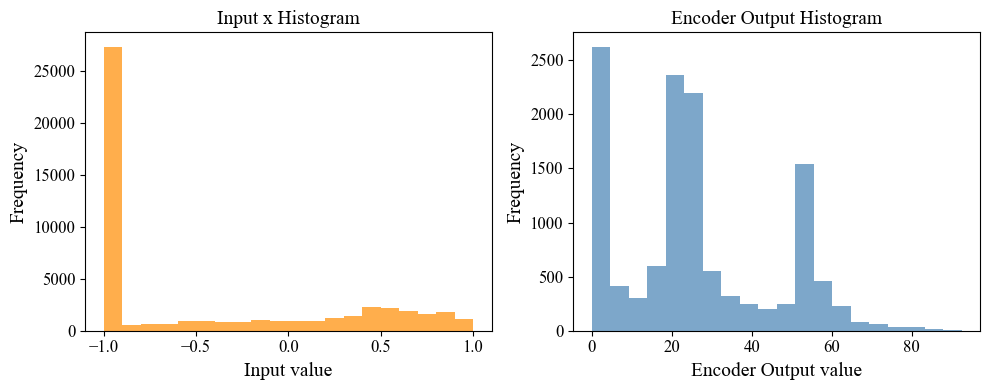

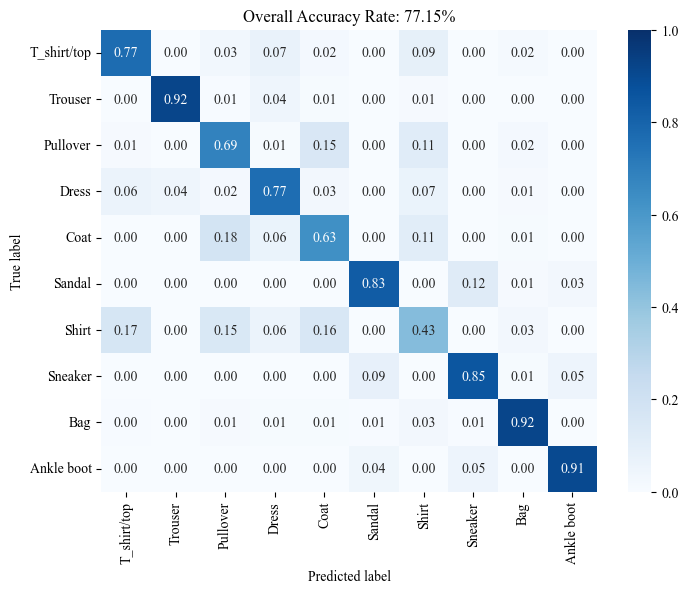

1:4 4th Epoch: 19/20

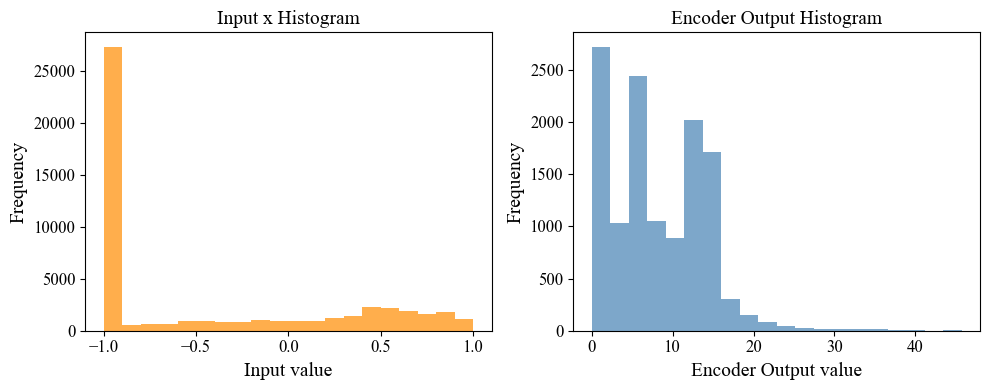

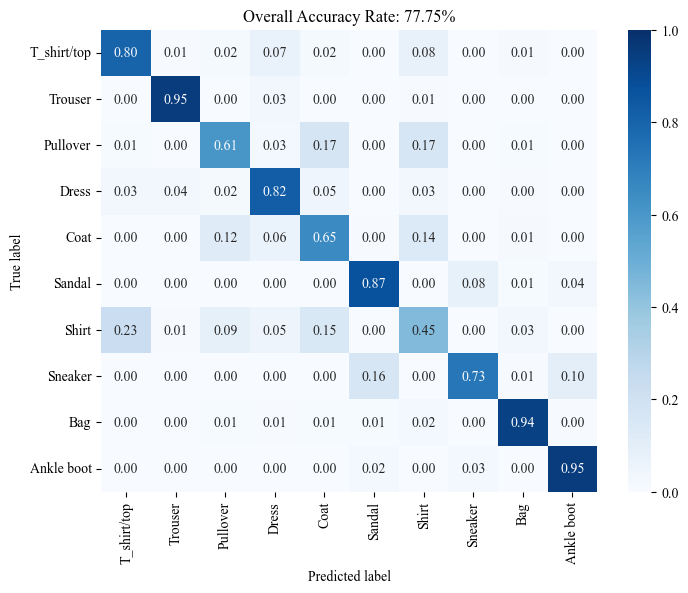

1:4 5th Epoch: 19/20

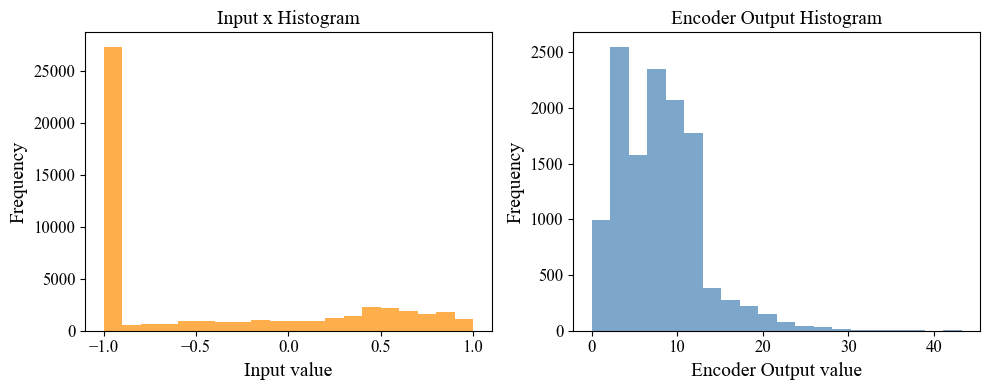

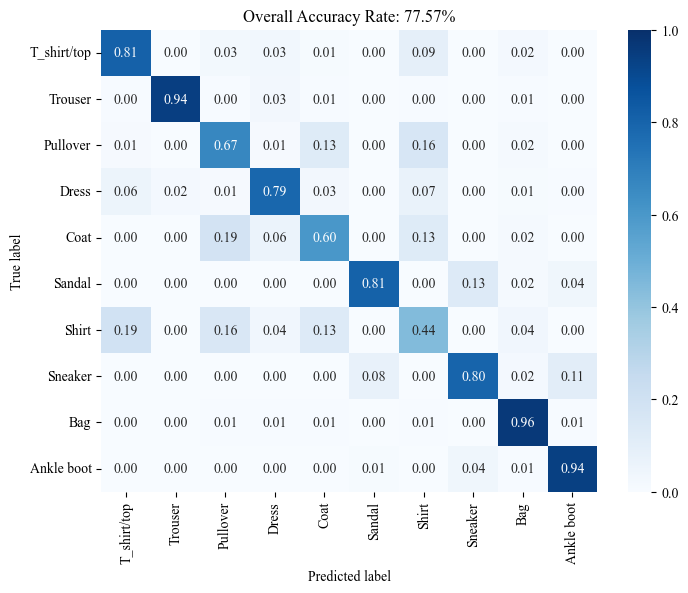

           Average  Best ID       Best  Worst ID     Worst
0   ACC  78.072000        2  79.250000         3  77.15000
1  LOSS   0.572749        1   0.550812         3   0.60392


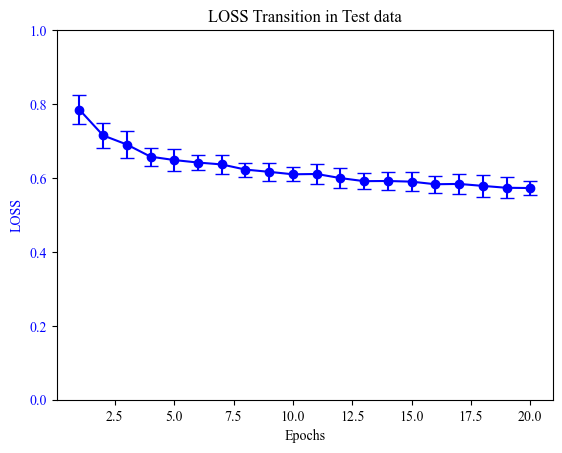

1:8 1th Epoch: 19/20

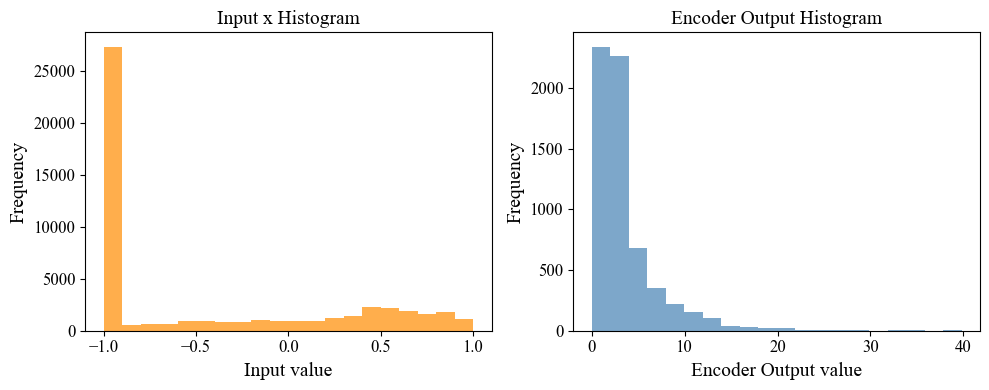

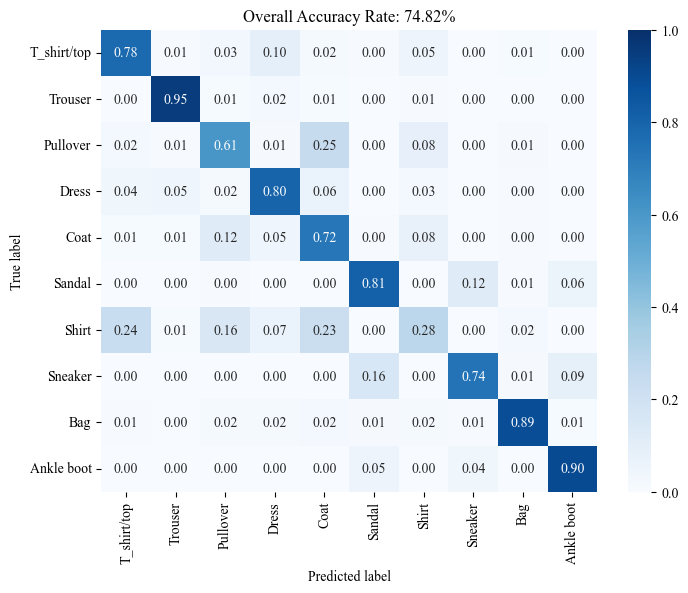

1:8 2th Epoch: 19/20

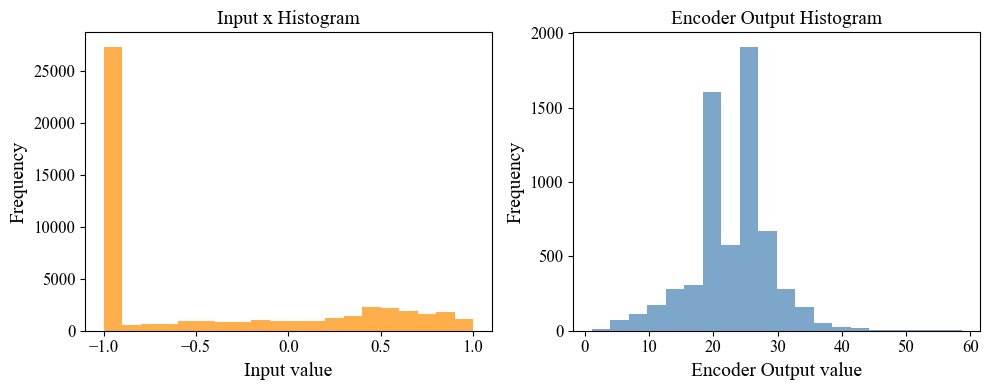

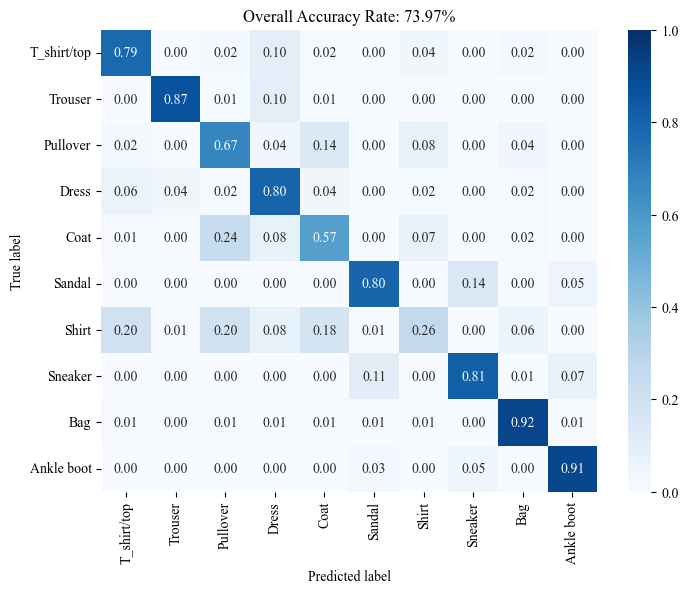

1:8 3th Epoch: 19/20

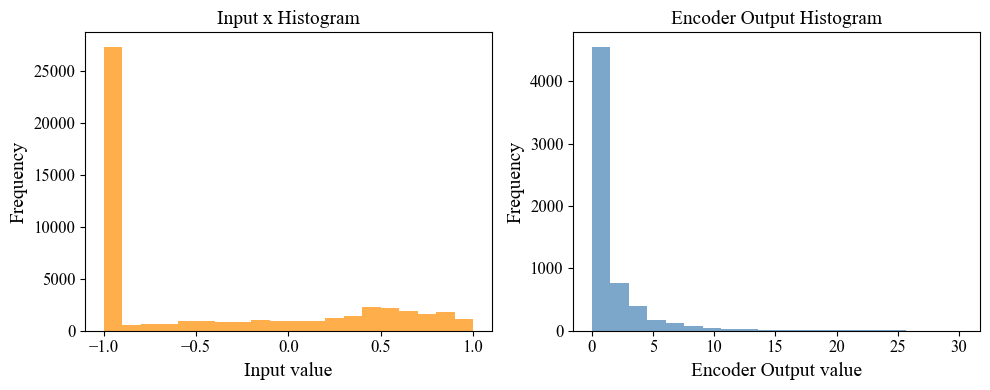

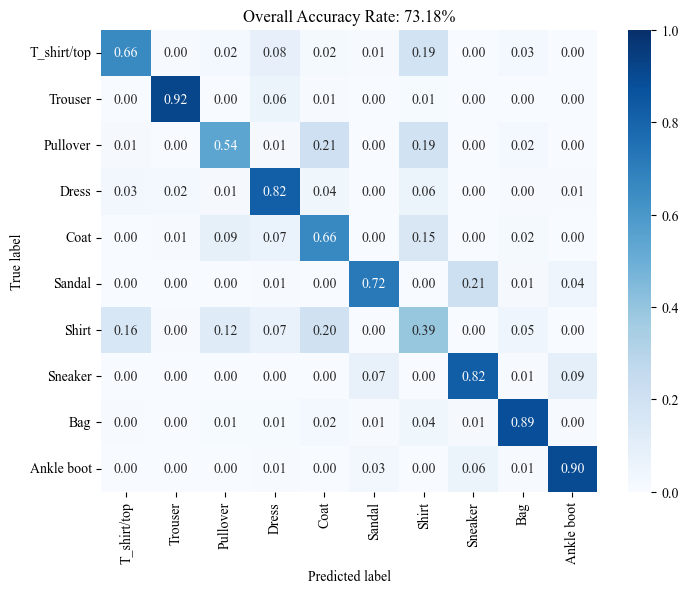

1:8 4th Epoch: 19/20

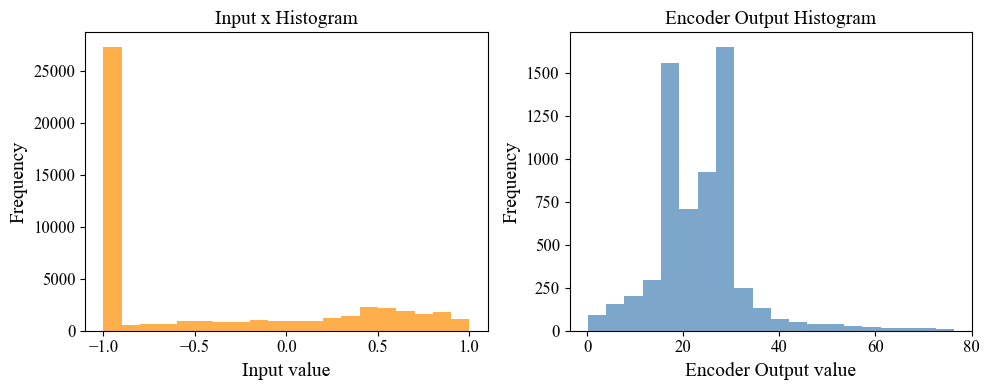

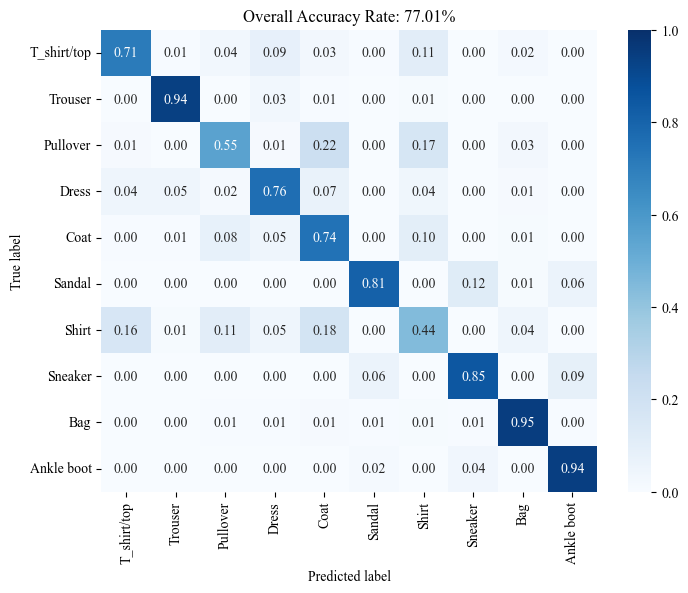

1:8 5th Epoch: 19/20

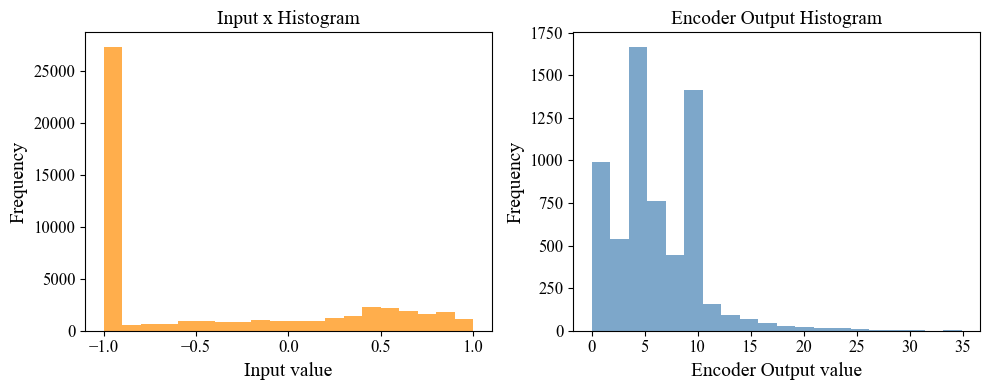

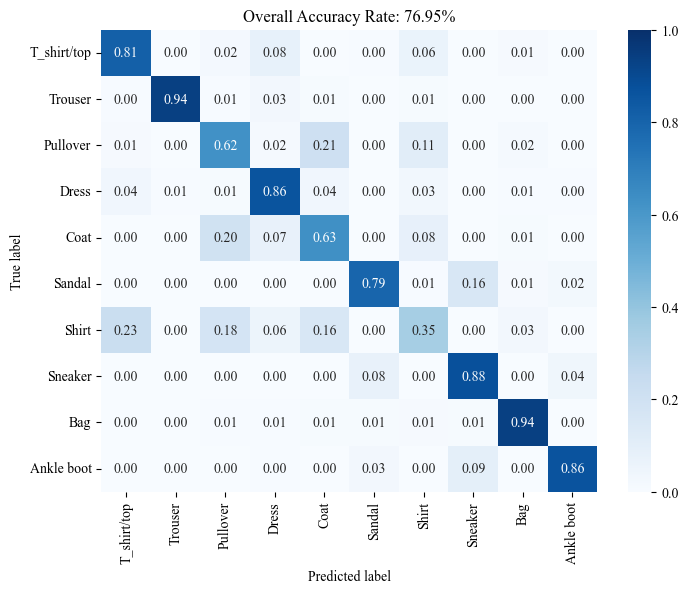

           Average  Best ID       Best  Worst ID      Worst
0   ACC  75.186000        4  77.010000         3  73.180000
1  LOSS   0.645918        5   0.597349         3   0.691601


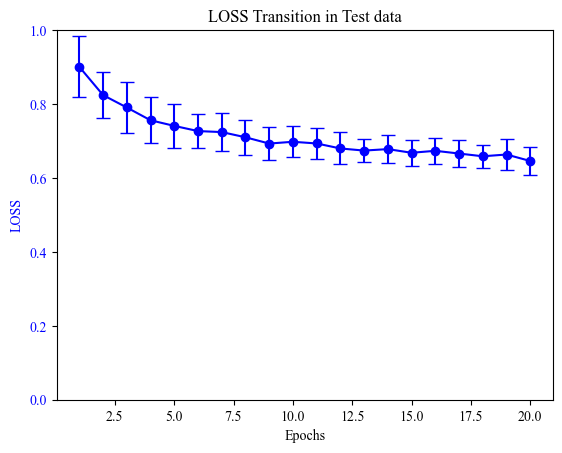

1:16 1th Epoch: 19/20

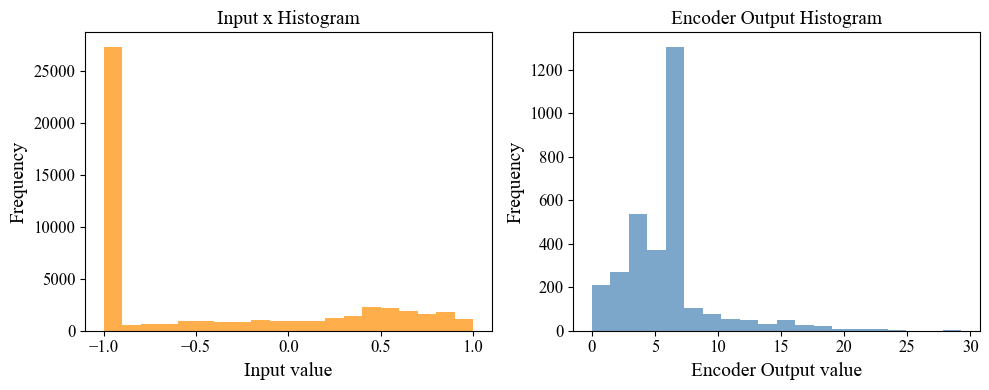

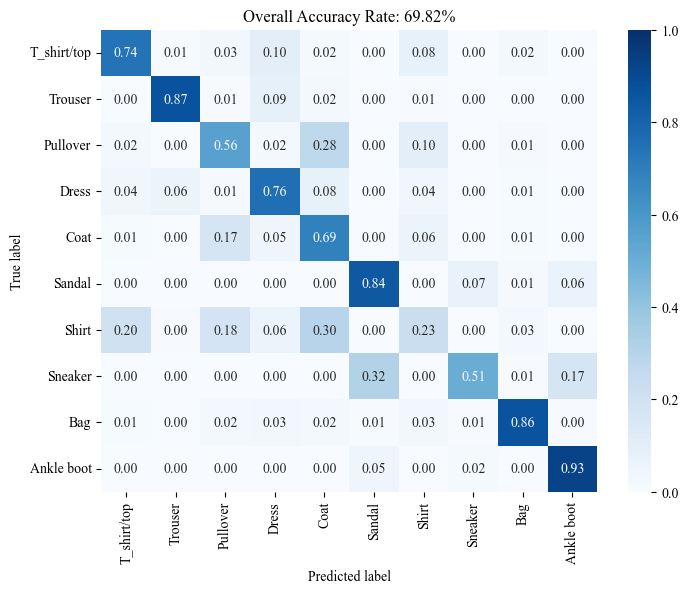

1:16 2th Epoch: 19/20

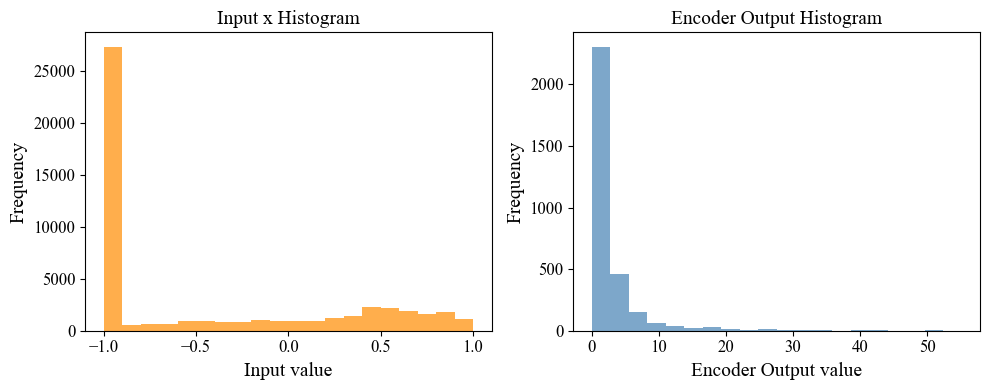

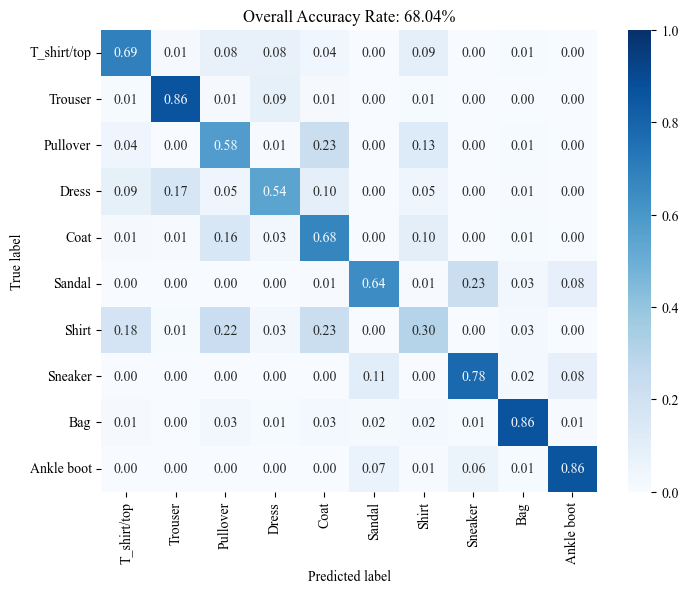

1:16 3th Epoch: 19/20

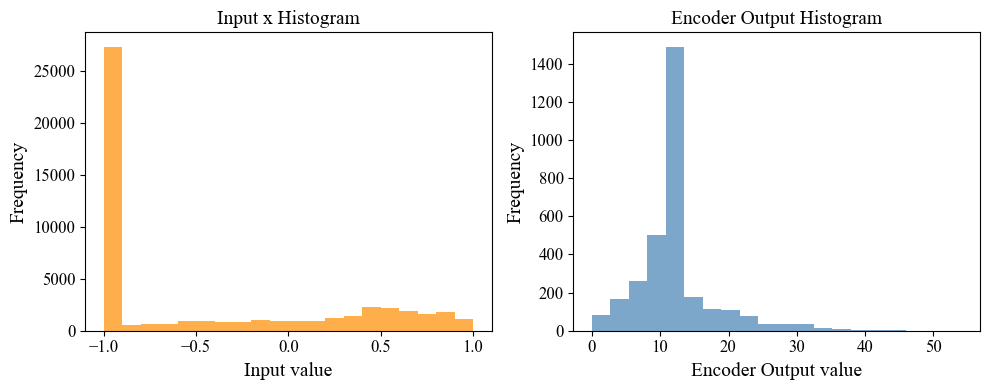

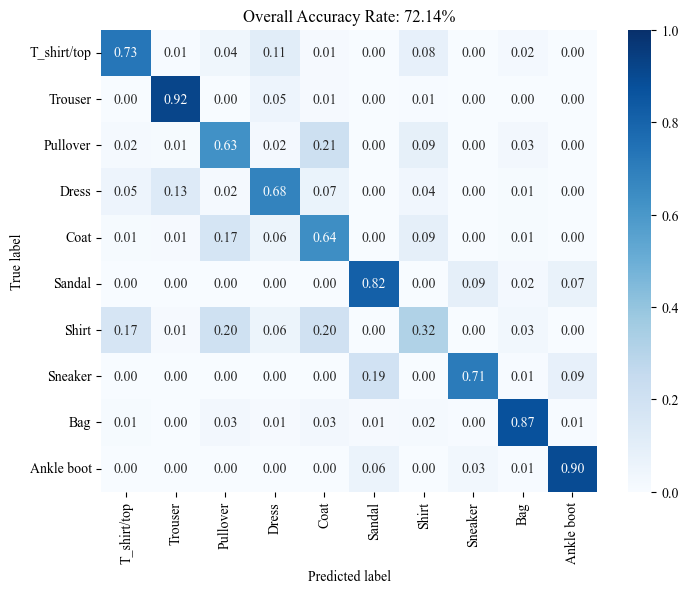

1:16 4th Epoch: 19/20

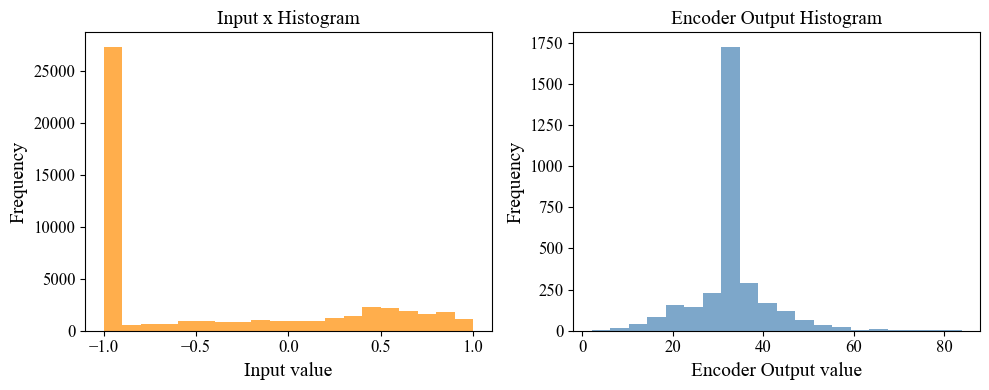

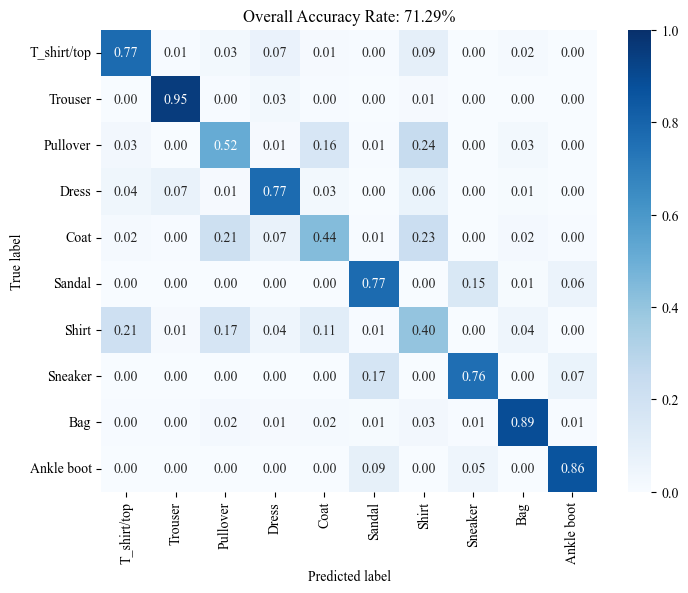

1:16 5th Epoch: 19/20

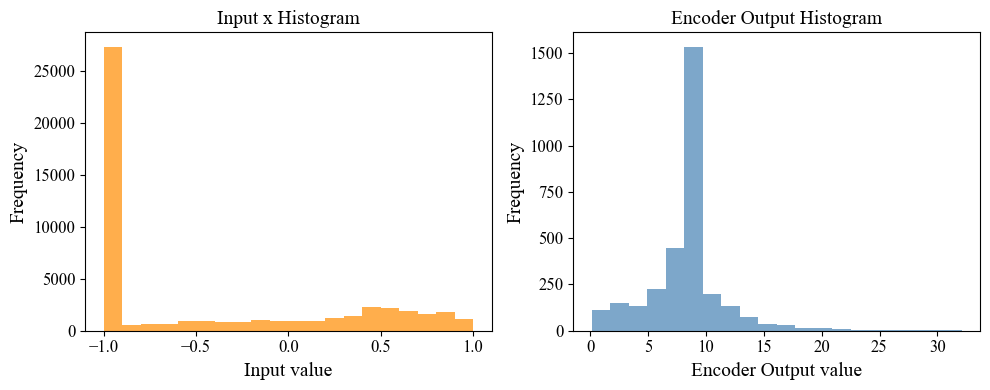

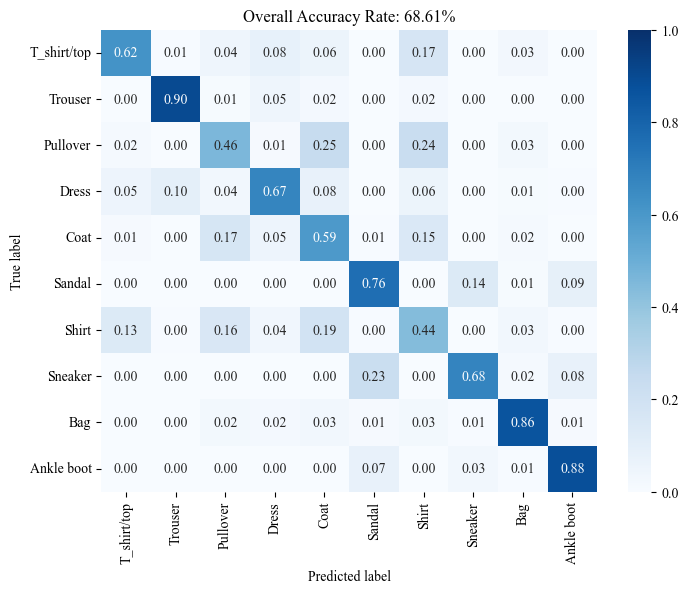

           Average  Best ID       Best  Worst ID      Worst
0   ACC  69.980000        3  72.140000         2  68.040000
1  LOSS   0.772824        3   0.719843         2   0.831473


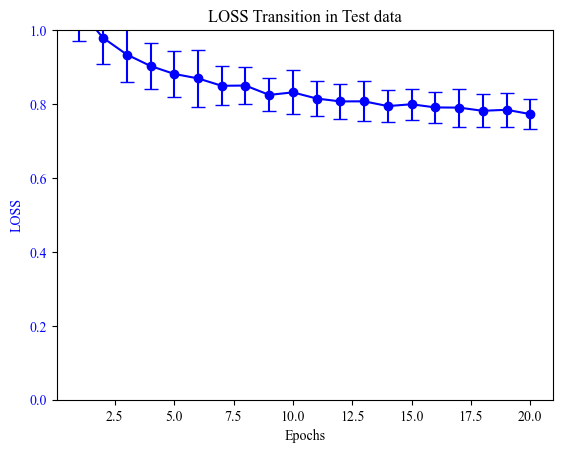

In [ ]:
img_size = 28
channels = 1

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
#leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
max_epochs = 20#20

num_try = 5##5

leverages = [1,2,4,8,16]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(1,num_try+1): 
        train_dataloader = get_new_dataloader(Fmnist_train,batch_size)
        model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                    
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, t) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)


            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                first_batch = True
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    _, predicted = torch.max(y, 1)
                    loss = criterion(y,t)
                    loss_test += loss.item()        
                    total += t.size(0)
                    correct += (predicted == t).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(t.cpu().numpy()) 
                    if epoch == max_epochs - 1:
                        if first_batch:
                            x = x.view(batch_size, channels, img_size, img_size)  
                            x_splitted = model.split(x, kernel_size)
                            x_in_flat = x_splitted.reshape(-1).detach().cpu().numpy()
                            x_encoded = model.encoder(x_splitted)
                            x_out_flat = x_encoded.reshape(-1).detach().cpu().numpy()

                            # サブプロットで横に並べて表示
                            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                            # 入力ヒストグラム
                            axes[0].hist(x_in_flat, bins=20, color='darkorange', alpha=0.7)
                            axes[0].set_xlabel("Input value", fontsize=14)
                            axes[0].set_ylabel("Frequency", fontsize=14)
                            axes[0].set_title("Input x Histogram", fontsize=14)
                            axes[0].tick_params(labelsize=12)
                            axes[0].set_ylim(0,)

                            # エンコーダ出力ヒストグラム
                            axes[1].hist(x_out_flat, bins=20, color='steelblue', alpha=0.7)
                            axes[1].set_xlabel("Encoder Output value", fontsize=14)
                            axes[1].set_ylabel("Frequency", fontsize=14)
                            axes[1].set_title("Encoder Output Histogram", fontsize=14)
                            axes[1].tick_params(labelsize=12)

                            plt.tight_layout()
                            plt.show()

                            first_batch = False
            
            #print(f"Test Accuracy: {100 * correct / total:.2f}%")
            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            #if epoch == max_epochs-1:
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]t6
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)
        fashion_labels = [
        "T_shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                     xticklabels=fashion_labels, yticklabels=fashion_labels,
                     vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Accuracy Rate: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    plt.ylim(0,1.0)
    plt.show()


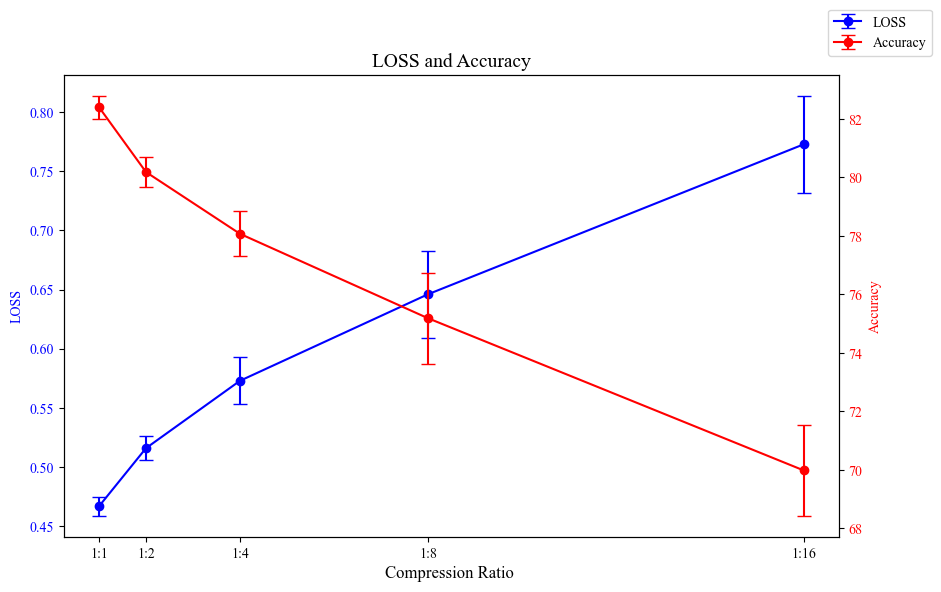

In [21]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[1,2,4,8,16]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [22]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

           Average  Best ID       Best  Worst ID      Worst
0   ACC  82.402000        3  82.720000         1  81.650000
1  LOSS   0.466588        2   0.457523         1   0.481327
2   ACC  80.184000        2  80.690000         1  79.400000
3  LOSS   0.515740        5   0.505265         1   0.532442
4   ACC  78.072000        2  79.250000         3  77.150000
5  LOSS   0.572749        1   0.550812         3   0.603920
6   ACC  75.186000        4  77.010000         3  73.180000
7  LOSS   0.645918        5   0.597349         3   0.691601
8   ACC  69.980000        3  72.140000         2  68.040000
9  LOSS   0.772824        3   0.719843         2   0.831473


In [23]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','FMNIST_texts')  
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CNN_VCR_PM_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

/Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/CODES/konishi_Classifer/data/FMNIST_texts
